# Individual Student Project (Luca Maggi 866654)

Analyze and compare two geospatial datasets


The choice of the datasets is free, but a few constraints must be observed.
* Use at least 2 different datasets (e.g. model and observations, n different models, 2 different observational datasets, etc.)
* Perform at least 1 operation in space and 1 operation in time (e.g. aggregation, normalization, resampling, regridding, etc.)
* Display data both as a function of space and time (time series and maps)
* Apply some sort of statistical analysis on the data (arrange the data according to some pdf, hypothesis testing, time series analysis, detection of trends, classification, pattern detection, ...)

## Introduzione

Per questo progetto sono impiegati tre dataset diversi, uno basato sulle osservazioni reali e due basati su modelli.

Il primo è il dataset *CRUTEM.5.0.0.0*, esso consiste in una compilation di 10 639 record estratti da stazioni di misurazione sparse per il mondo, di queste, però, solo poco più di 7 700 hanno sufficienti dati per poter esser impiegate nell'analisi.
I dataset basati sui modelli cliamtici scelti sono denominati *IPSL-CM6A-LR* e *MIROC6*. Durante lo svolgimento del progetto questi ultimi sono uniti in un unico modello ensemble, che viene poi utilizzato per le varie analisi. 

L'idea alla base è quella di favorire un confronto tra le anomalie ricavate dalle osservazioni e quelle ricavate dai modelli climatici, sintetizzati dal modello ensemble.  
Dopo una breve presentazione dei dataset a disposizione vengono calcolate le anomalie di temperatura rispetto ad un periodo di riferimento; definite mese per mese come la differenza tra tutte le osservazioni e la media dei dati nel periodo prescelto.  

I dati a disposizione sono mensili, essi coprono un periodo che si estende dal 1850 al 2022 per il dataset ricavato dalle osservazioni, mentre solo dal 1850 al 2015 per il modello ensemble. Il periodo considerato per il confronto tra i modelli sarà quindi il secondo, mentre il periodo rispetto al quale sono calcolate le anomalie è quello che varia dal 1961 al 1991. Questa scelta è consistente col fatto che il dataset *CRUTEM.5.0.0.0* contiene già la media, calcolata rispetto ad ogni mese, per questo periodo.

L'operazione compiuta per ottenere le anomalie è quindi la seguente: ANOMALIA(y,m) = DATA(y,m) - MEDIA([periodo 1961-1991])(m) , per ogni mese (m = 1, 2, ..., 12), per ogni anno (y = 1850, 1851, ...) 

Infine, come ultimo passaggio dell'analisi, dopo aver confrontato le anomalie, si applica una Empirical Orthogonal Function (EOF) al dataset ensemble, nella speranza di poter osservare dei pattern interessanti nelle anomalie stesse. 

In [1]:
# Imports

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
from eofs.xarray import Eof
import os

import numpy as np
import pandas as pd
import pyproj
import geopandas as gpd

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import nc_time_axis
import math
from scipy import stats

## Dataset CRUTEM.5.0.0.0

Il dataset è composto da molteplici stazioni e per ognuna di esse sono forniti dei metadati quali: la latitudine, la longitudine, il nome, il paese in cui risiede, il suo ID univoco, ...  

Come primo passaggio il dataset deve essere adeguatamente acquisito.  
A questo scopo esso è scomposto in tre dataframe distinti, il primo contiene tutti i metadati che possono essere utili per l'analisi, il secondo usa come chiave l'ID della stazione e contiene tutte le osservazioni; il terzo ha 12 righe, una per ogni mese, e contiene i valori detti "normali", calcolati per ogni mese come precedentemente accennato e già presenti nel dataset.

In particolare si segnalano le variabili:  

* tas_climatology_normal = I valori normali calcolati come sopra
* tas = La serie delle osservazioni registrate dalle stazioni

Dopo l'acquisizione è tracciato un grafico in cui sono mostrate tutte le stazione valide per l'analisi e la loro collocazione sulla mappa geografica.

In [2]:
# Import del dataset 

flist = [os.path.join(path, name) for path, subdirs, files in os.walk("./CRUTEM.5.0.0.0.station_files") for name in files]
for i in range(1,5):
    print (flist[i])

print ('\n',flist[0:5])
nst=len(flist)
print ("\n > Number of stations = ", nst)

./CRUTEM.5.0.0.0.station_files\01\010030.nc
./CRUTEM.5.0.0.0.station_files\01\010050.nc
./CRUTEM.5.0.0.0.station_files\01\010070.nc
./CRUTEM.5.0.0.0.station_files\01\010080.nc

 ['./CRUTEM.5.0.0.0.station_files\\01\\010010.nc', './CRUTEM.5.0.0.0.station_files\\01\\010030.nc', './CRUTEM.5.0.0.0.station_files\\01\\010050.nc', './CRUTEM.5.0.0.0.station_files\\01\\010070.nc', './CRUTEM.5.0.0.0.station_files\\01\\010080.nc']

 > Number of stations =  10639


In [3]:
metadata0 = pd.DataFrame(columns=['ID','stname','country','lat','lon'])
data_normals = pd.DataFrame({'time': range(1,13)})
data_normals.set_index('time', inplace=True)

In [4]:
# Le staioni contenute nel dataset coprono spesso differenti periodi temporali. 
# Qui viene identificata la stazione che copre il periodo più lungo (1850-2022), questo periodo è quindi preso come riferimento
# per uniformare anche le altre stazioni

nst_tmp = nst 
lunghezza = {}
i = 0

for si in (range(0,nst_tmp)):
    
  
    filein=flist[si]
    
    d1 = xr.open_dataset(filein)
    lunghezza[i]= len(d1.time.values)
    i+=1
    
    
ht_key = max(lunghezza, key=lunghezza.get)
ht_value = lunghezza[ht_key]
print(f'stazione numero: {ht_key}, con {ht_value} mesi (dal 1850 al 2022)')

stazione numero: 41, con 2076 mesi (dal 1850 al 2022)


In [5]:
ht_value=2076 # come riferimento sono presi i 2076 mesi trovati nel calcolo precedente


nmonths=ht_value - 12 # taxis arriva fino al 12/2022, ma i mesi con dati si fermano al 02/2022
nyears=nmonths/12

taxis = xr.open_dataset(flist[41]).time.values
taxis = taxis[:2064]

data0 = pd.DataFrame({'time': taxis})

In [6]:
# Acquisizione del Dataset 

nst_tmp = nst 

# counter per diagnostica

nodatacount=0  
tooshortcount=0 
outsidecount=0

for si in (range(0,nst_tmp)):
    
  
    filein=flist[si]

    # Scan del file per trovare dati assenti
    
    d1 = xr.open_dataset(filein)
    if len(d1.tas.values) < 1:
        nodatacount+=1    
        continue
        
    # Trovare quanti anni ci sono nella time series per la stazione, filtro sulla lunghezza della serie storica

    nyr = len(d1.time.values)/12
    
    # filtro le serie con meno di 20 anni
    
    if (nyr < 20):
        tooshortcount+=1 
        continue       

    # Filtro stazioni con NAN values per ogni mese nel calcolo del ciclo medio annuo

    norm_value = [value for value in d1.tas_climatology_normal.values]
    if np.isnan(norm_value).any():
        outsidecount+=1
        continue
        
    # Scan del file per trovare lat/lon assenti
    
    d1 = xr.open_dataset(filein)
    lat = d1.latitude.values
    lon = d1.longitude.values
    if np.isnan(np.array((lat,lon))).any():
        outsidecount+=1
        continue
        
    # Per le stazioni trattenute, recupero nome, paese, id della stazione, latitudine,
    #longitudine, periodo di riferimento, serie delle temperature, normali (già calcolate nel dataset)

    stname = d1.attrs['name']    
    country = d1.attrs['country'] 
    ID = d1.attrs['stationid']
    lat = d1.latitude.values
    lon = d1.longitude.values      
    time = pd.to_datetime(d1.time.values, format= "%Y/%m/%d", exact=True)
    ts = d1.tas.values
    normals = d1.tas_climatology_normal.values
 
    # Costruisco il df dei metadati

    metadata0 = pd.concat([metadata0,
        pd.DataFrame.from_records([{
        "ID": ID,
        "stname": stname,
        "country": country,
        "lat":  lat,      
        "lon":  lon
        }])])

    # costruzione del df delle stazioni (con il loro ID)

    xdf = pd.DataFrame({'time': time})
    xdf[f"{ID}"] = ts
    
    # merging a quello globale su ID

    data0 = pd.merge(data0, xdf, on= 'time', how='left')
        
    # costruzione del df delle normali
    
    data_normals = pd.concat([data_normals,
        pd.DataFrame.from_records({
        f"{ID}": normals
        }, index=(range(1,13)))], axis=1)
    
    
data0.set_index('time', inplace=True)
metadata0.set_index('ID', inplace=True)
data_normals.index.name = 'time'

In [7]:
# Risultato dell'acquisizione

print(nodatacount,' stations with no data (not acquired)')
print(tooshortcount,' stations with too little data (not acquired)')
print(outsidecount,' stations with not enough data for the ref. period (not acquired)')
print("{} valid stations acquired".format(len(data0.columns)))

0  stations with no data (not acquired)
1018  stations with too little data (not acquired)
1906  stations with not enough data for the ref. period (not acquired)
7715 valid stations acquired


In [8]:
# DF dei metadati

print(metadata0)

                      stname        country    lat    lon
ID                                                       
010010             Jan Mayen         NORWAY   70.9   -8.7
010050         ISFJORD RADIO         NORWAY   78.0   14.2
010070            NY-ALESUND         NORWAY   78.9   11.9
010080     Svalbard Lufthavn         NORWAY   78.3   15.5
010100               ANDENES         NORWAY   69.3   16.2
...                      ...            ...    ...    ...
997546  MATROOSBERG---------  SOUTH-AFRICA-  -33.4   19.8
998504      MLINGANO NGOMENI       TANZANIA   -5.2   38.9
998513     ILONGA MET OFFICE       TANZANIA   -6.8   37.0
999202  BALCARCE-INTA(BUENOS      ARGENTINA  -37.8  -58.3
999221           T2004.PASOI      ARGENTINA  -38.5  -69.4

[7715 rows x 4 columns]


In [9]:
# Dataframe dei valori registrati dalla stazione (un sample)

print(data0.iloc[1600:1605,0:10])

                     010010  010050  010070  010080  010100  010101  010150  \
time                                                                          
1983-05-16 12:00:00    -0.1     NaN    -2.8    -3.4     7.0     8.5     6.8   
1983-06-16 00:00:00     1.6     NaN     0.7     1.1     8.1     9.2     8.4   
1983-07-16 12:00:00     4.4     NaN     5.2     6.0    10.7    11.9    10.9   
1983-08-16 12:00:00     4.3     NaN     3.3     4.1     9.2     9.9     9.4   
1983-09-16 00:00:00     1.9     NaN     0.6     1.0     8.8     9.4     9.2   

                     010170  010230  010250  
time                                         
1983-05-16 12:00:00     7.7     8.1     7.1  
1983-06-16 00:00:00     9.0     9.8     8.7  
1983-07-16 12:00:00    12.0    12.4    11.6  
1983-08-16 12:00:00     9.4     9.5     8.7  
1983-09-16 00:00:00     9.4     8.7     8.6  


In [10]:
# DF dei valori normali (già calcolati nel dataset originale)

print(data_normals)

      010010  010050  010070  010080  010100  010101  010150  010170  010230  \
time                                                                           
1     -5.743 -12.194 -13.448 -15.340  -2.083  -2.763  -2.140  -4.307 -10.343   
2     -6.140 -12.725 -14.138 -16.250  -2.157  -2.441  -1.987  -4.143  -8.883   
3     -6.067 -12.381 -13.695 -15.710  -1.427  -0.778  -0.963  -2.463  -4.703   
4     -3.883  -9.887 -10.976 -12.293   0.990   1.844   1.587   0.957   0.263   
5     -0.667  -3.688  -3.376  -4.327   5.157   6.333   5.341   5.518   5.923   
6      2.007   1.531   1.795   1.987   8.557  10.226   8.693   9.721  10.780   
7      4.210   4.787   5.129   5.767  11.040  12.670  11.164  11.909  13.030   
8      4.950   4.120   4.059   4.670  11.053  12.048  11.104  11.555  11.983   
9      2.767   0.800   0.182   0.260   7.800   8.211   7.950   7.688   6.850   
10     0.057  -4.187  -5.309  -5.447   4.193   4.189   4.493   3.558   1.487   
11    -3.293  -8.175  -9.768 -10.270   0

In [11]:
# Controllo che la latitudine e la longitudine siano in formato adeguato

print(f'range longitudine: {metadata0.lon.min()} , {metadata0.lon.max()}; range latitudine: {metadata0.lat.min()} , {metadata0.lat.max()}')

range longitudine: -180.0 , 179.6; range latitudine: -90.0 , 82.5


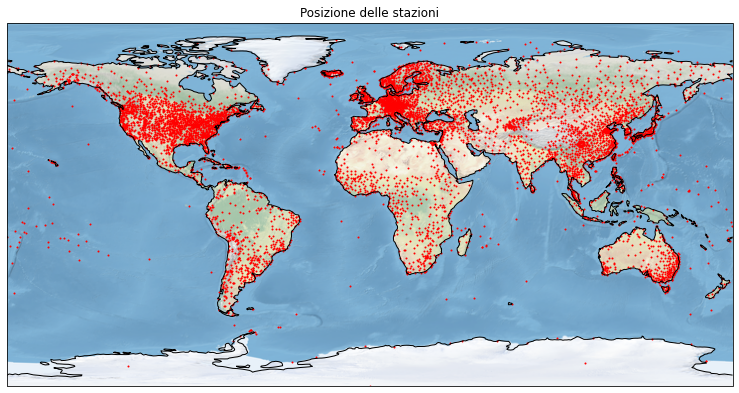

In [12]:
# Disposizione geografica delle stazioni nel dataset

fig = plt.figure(figsize=(13,13))  
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([metadata0.lon],[metadata0.lat],color='r',marker='o',s=1.0)
plt.title('Posizione delle stazioni')
plt.show()

Si procede a calcolare e rappresentare la temperatura media complessiva registrata dalle stazioni lungo tutto il loro arco operativo e la rispettiva deviazione standard.  
Per fare ciò è necessario suddividere il mondo con una griglia 5x5 per poi calcolare il valore di ogni cella come la media dei valori delle stazioni che ne sono comprese. Inoltre, prima di compiere l'aggregazione, le celle sono pesate per compensare la maggiore o minore area che una modellazione della terra di questo tipo comporta.

In [13]:
# Creazione della griglia 5x5

resol = 5
nlon = int(360/resol)
nlat = int(180/resol)

grlons = np.empty([nlon+1],dtype='float') 
grlats = np.empty([nlat+1],dtype='float') 
grlons[0] = -180.
grlats[0] = -90.
for i in range(1,nlon+1):
  grlons[i]=grlons[i-1]+resol
for i in range(1,nlat+1):
  grlats[i]=grlats[i-1]+resol

In [14]:
# Creazione del df mensile delle temperature

data_mo_1 = np.empty([nmonths,nlat,nlon],dtype=float)
data_mo_1[:,:,:] = np.nan

for j in range(0,nlat):
  for i in range(0,nlon):
    
    dummy = metadata0[metadata0.lon >= grlons[i]]
    dummy = dummy[dummy.lon < grlons[i+1]]
    dummy = dummy[dummy.lat >= grlats[j]]
    dummy = dummy[dummy.lat < grlats[j+1]]

    if (len(dummy.index) > 0):
        
      data_mo_1[:,j,i] = np.array(data0[dummy.index].mean(axis=1)).flatten()

In [15]:
# Trasformazione del df precedente in un formato un Xarray Dataset 

data_mese = xr.DataArray(
    data=data_mo_1,
    dims=["time","lat", "lon"],
    coords=dict(
        lat=(["lat"], grlats[:-1]),
        lon=(["lon"], grlons[:-1]),
        time=pd.date_range('1850-01', '2022-01', freq='M')
    ),
    attrs=dict(
        description="Surface Temperature",
        units="°C",
    ),
)

data_mese = data_mese.to_dataset(name='ts')

# Calcolo dei pesi e computazione della media e della deviazione standard pesate

weights = np.cos(np.deg2rad(data_mese.lat))

stat_mean_time = data_mese.ts.mean('time')
stat_std_time = data_mese.ts.std('time', skipna =True)

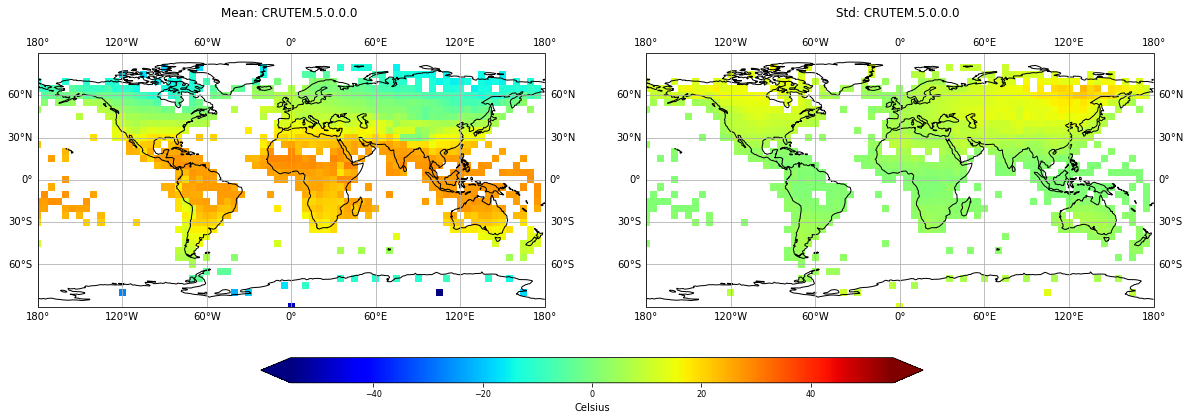

In [17]:
# Rappresentazione mediante due grafici, il primo rappresenta le temperature medie lungo tutto il periodo temporale, il secondo rappresenta la loro deviazione standard

fig = plt.figure(figsize=(20,7))  

subplots = (1,2)
n_panels = subplots[0] * subplots[1]
tmax = np.abs(stat_mean_time).max()
norm = mpl.colors.Normalize(vmin=-tmax,vmax=tmax) 
cmap = mpl.cm.seismic

# Media dataset

ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Mean: CRUTEM.5.0.0.0',  '\n']))
ax.set_global()
mm = ax.pcolormesh(data_mese.lon, data_mese.lat, stat_mean_time, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto')  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Std dataset

ax = fig.add_subplot(subplots[0], subplots[1], 2, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Std: CRUTEM.5.0.0.0', '\n']))
ax.set_global()
mm = ax.pcolormesh(data_mese.lon, data_mese.lat, stat_std_time, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto' )  
ax.coastlines()
ax.gridlines(draw_labels=True)

# colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.75)
cbar.set_label('Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

Vengono quindi calcolate le anomalie come differenza tra le osservazioni ed i valori normali mediante metodo elencato nell'introduzione, in questo calcolo è tenuto debitamente conto anche del mese.  
Si crea così prima un dataframe mensile, sulla base della griglia di cui sopra, poi questo è mediato temporalmente e transformato in un dataframe annuale.  

Ottenuti i dati relativi alla media annuale delle anomalie per ogni quadrante della griglia e ottenute le coordinate dei quadranti stessi vengono proposti due grafici riassuntivi.  
Il primo mostra una mappa del mondo suddivisa nella griglia 5x5, all'interno di ogni cella la presenza di una croce rossa indica se, per quel quadrante, vi sono stazioni e, quindi, osservazioni disponibili; il secondo è una serie temporale delle anomalie medie (in rosso), accompagnate dalle anomalie per ogni singola cella lungo tutto il periodo (in grigio).

In [18]:
# Creazione del df delle anomalie

data_anom = data0.copy(deep=True)
y0=0
for yi in range(0,int(nyears)):
    data_anom.iloc[y0:y0+12,:] = data0.iloc[y0:y0+12,:]-np.array(data_normals.iloc[:,:])
    y0+=12

In [19]:
# Creazione del df delle anomalie mensile e annuale

data_mo = np.empty([nmonths,nlat,nlon],dtype=float)
data_mo[:,:,:] = np.nan

data_yr = np.empty([int(nyears),nlat,nlon],dtype=float)
data_yr[:,:,:] = np.nan

for j in range(0,nlat):
  for i in range(0,nlon):
    
    dummy = metadata0[metadata0.lon >= grlons[i]]
    dummy = dummy[dummy.lon < grlons[i+1]]
    dummy = dummy[dummy.lat >= grlats[j]]
    dummy = dummy[dummy.lat < grlats[j+1]]

    if (len(dummy.index) > 0):
        
      data_mo[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1)).flatten()
      data_yr[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1).resample("Y").mean()).flatten()

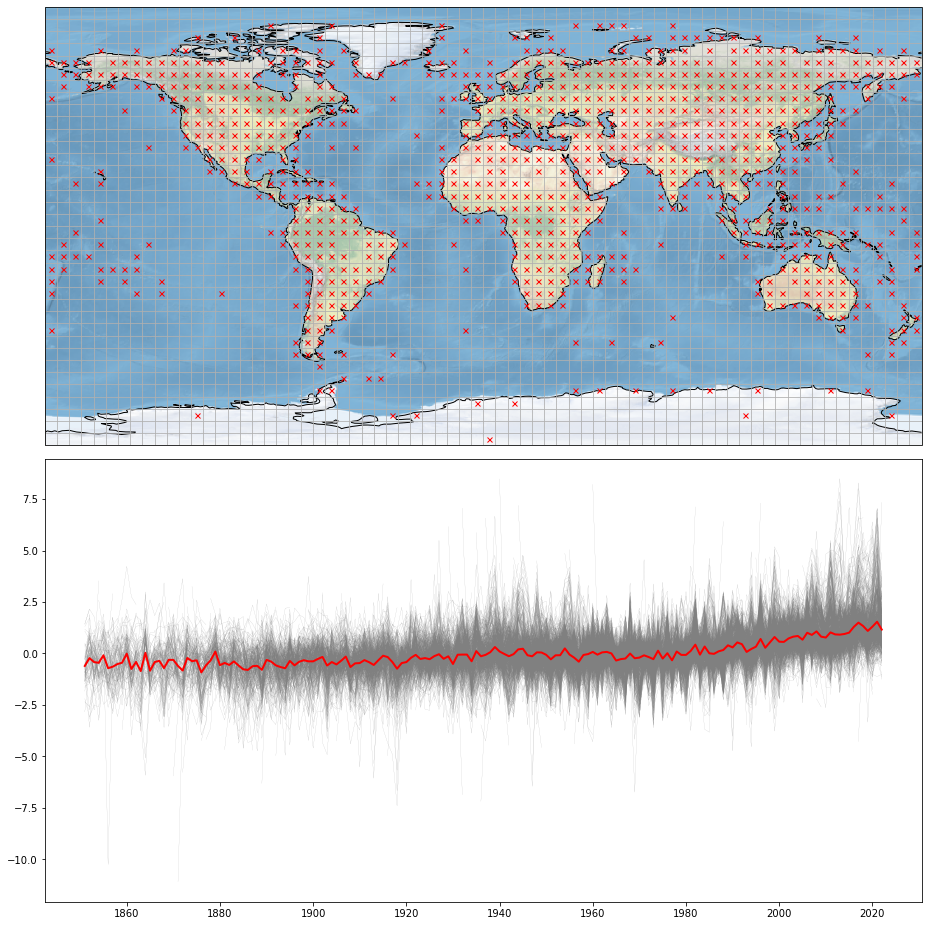

In [20]:
# Grafici

# Primo grafico

fig = plt.figure(figsize=(13,13))  
subplots = (2,1)

ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))

tser = fig.add_subplot(subplots[0], subplots[1], 2)


data_glob = np.empty([int(nyears)],dtype=float)
data_glob[:] = np.nan

# Mappa e marker per le celle contenenti i dati

for j in range(0,nlat):
  for i in range(0,nlon):
    
    # Controllo se la cella contiene dei dati
    
    if not(np.isnan(data_yr[:,j,i]).all()):
     
      #  Marker sulla mappa

      ax.plot( grlons[i:i+2].sum()/2, grlats[j:j+2].sum()/2,
         color='red', marker='x', markersize=5,transform=ccrs.PlateCarree())     
      plt.plot(pd.date_range('1850-01', '2022-01', freq='Y'),data_yr[:,j,i],color='gray',linewidth=0.1) 

# Secondo grafico    
        
for t in range(0,int(nyears)):  

    local = data_yr[t,:,:]
    valid = np.isnan(data_yr[t,:,:])
    data_glob[t] = np.nanmean(local[~valid])

# plot the global average curve  
    
plt.plot(pd.date_range('1850-01', '2022-01', freq='Y'), data_glob[:],color='red',linewidth=2) 

fig.tight_layout()  
plt.show() 

## Modelli  IPSL-CM6A-LR e MIROC6

Per il trattamento di questi modelli, dopo averli debitamente estratti, si procede omogeneizzando il *MIROC6* sulla base del *IPSL-CM6A-LR* mediante una interpolazione lineare per poterli così ricondurre alla stessa forma. Compiuta questa fase si procede a dei piccoli aggiustamenti per quanto riguarda la longitudine e i gradi (da Kelvin a Celsius).

A questo punto si aggregano i due modelli per costruire il modello ensemble che servirà come base per le successive analisi.

In [21]:
# Estrazione del modello

modfile1='./ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
m_variable='./ts_Amon_'
m_case='_historical_r1i1p1f1_gr_185001-201412.nc'
model1=modfile1[len(m_variable):-len(m_case)]

modfile2='./ts_Amon_MIROC6_historical_r1i1p1f1_gn_185001-201412.nc'
model2=modfile2[len(m_variable):-len(m_case)]

d1 = xr.open_dataset(modfile1)
d2 = xr.open_dataset(modfile2)

In [22]:
# Interpolazione lineare del secondo sulla forma del primo

d2 = d2.interp_like(d1, method='linear')

In [23]:
# Correzione longitudine [0,360] ==> [-180,180]

d1.coords['lon'] = (d1.coords['lon'] + 180) % 360 - 180
d1 = d1.sortby(d1.lon)

d2.coords['lon'] = (d2.coords['lon'] + 180) % 360 - 180
d2 = d2.sortby(d1.lon)

In [24]:
# Cambiamento gradi da Kelvin a Celsius

d1.ts.values = d1.ts.values-273.15
d2.ts.values = d2.ts.values-273.15

d1.ts.attrs["units"] = "°C"
d2.ts.attrs["units"] = "°C"

In [25]:
# Costruzione del modello ensemble

ens = d1.merge(d2.ts.rename('ts2'))

Anche per questi modelli si fornisce un rappresentazione riassuntiva del valore medio delle temperature da loro previste e la relativa deviazione standard. In particolare prima sono mostrati i valori del modello *IPSL-CM6A-LR*, poi del *MIROC6* e, infine, come confronto, del modello ensemble formato dall'unione dei due.  

Per ottenere questo risultato è creato un dataset contenente i valori mediati temporalmente dei due modelli (in modo da lasciare solo la latitudine e la longitudine come dimensioni), le loro deviazioni standard, la loro media (ovvero il valore del modello ensemble) e la rispettiva deviazione standard.  
Tutti i valori appena descritti sono pesati per correggre la distorsione dell'area che si riscontra tra le varie celle.

In [26]:
# Calcolo dei pesi per trovare la media pesata in base all'area 

weights1 = np.cos(np.deg2rad(d1.lat))
weights2 = np.cos(np.deg2rad(d2.lat))

In [27]:
# Creazione dataset geo mediato per il tempo (con solo la latitudine e la longitudine come dimensioni)

ens_geo = xr.Dataset()
ens_geo['ts'] = ens.ts.mean(("time"),keep_attrs=True)
ens_geo['ts2'] = ens.ts2.mean(("time"))

ens_mean_time = ens_geo.to_array(dim='new').mean('new')
ens_std_time= ens_geo.to_array(dim='new2').std('new2')

ens_geo['ens_mean_time'] = ens_mean_time
ens_geo['ens_std_time'] = ens_std_time

ens_geo['ts_std'] = ens.ts.std(("time"),keep_attrs=True)
ens_geo['ts2_std'] = ens.ts2.std(("time"))

ens_geo

<xarray.Dataset>
Dimensions:        (lat: 143, lon: 144)
Coordinates:
  * lat            (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon            (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
Data variables:
    ts             (lat, lon) float32 -52.88 -52.88 -52.88 ... -17.57 -17.57
    ts2            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ens_mean_time  (lat, lon) float64 -52.88 -52.88 -52.88 ... -17.57 -17.57
    ens_std_time   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ts_std         (lat, lon) float32 14.18 14.18 14.18 ... 12.56 12.56 12.56
    ts2_std        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

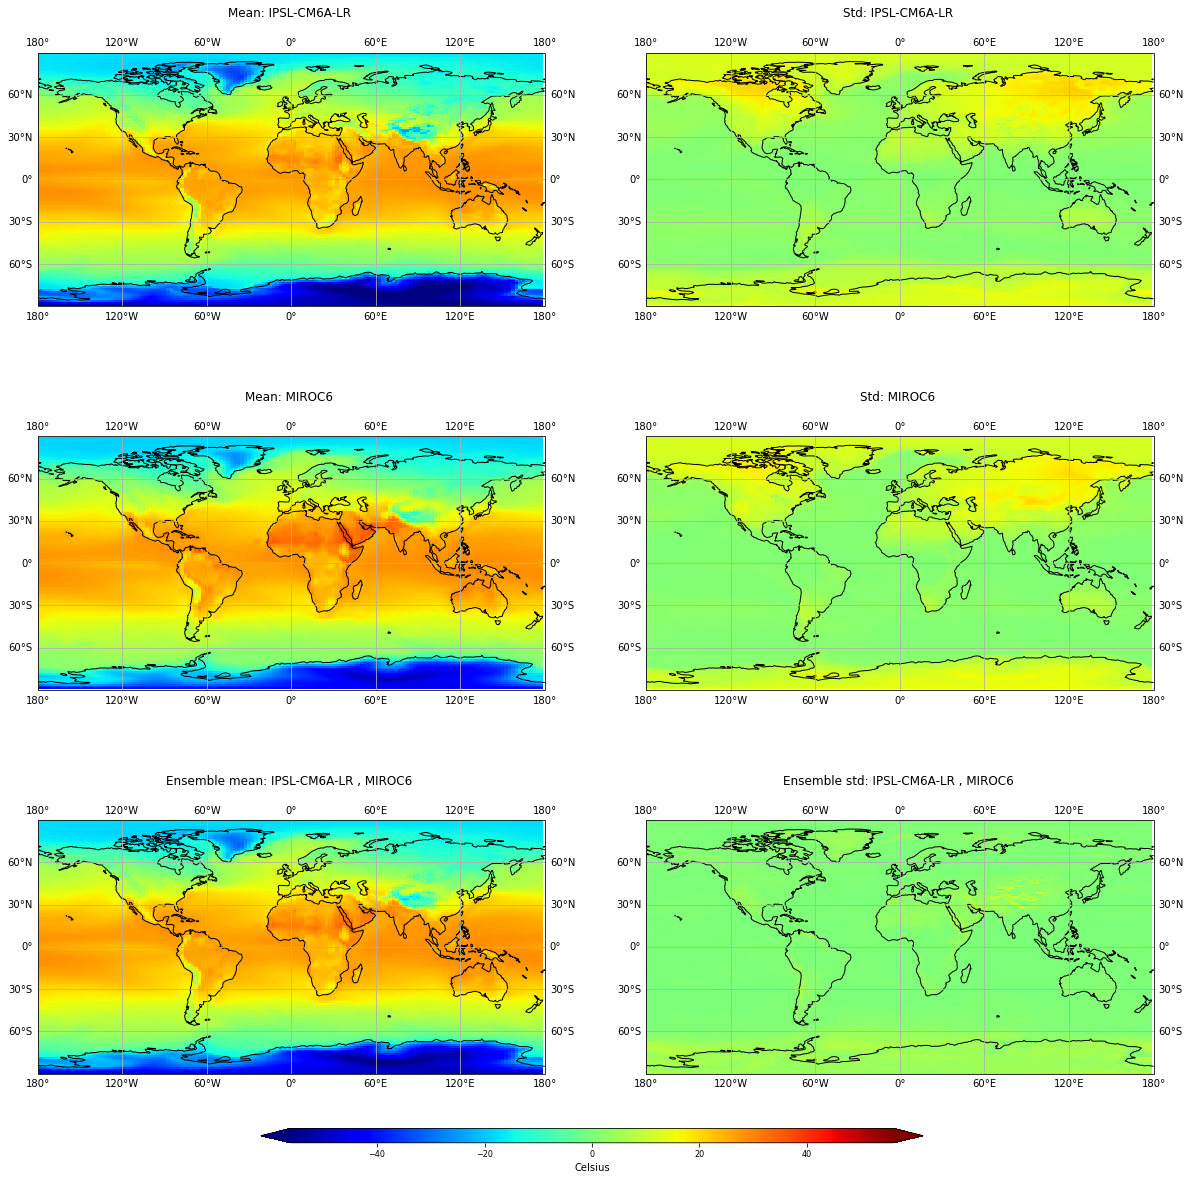

In [28]:
# Grafico riassuntivo di media e deviazione standard per i modelli singoli e il modello ensemble

fig = plt.figure(figsize=(20,20)) 

subplots = (3,2)
n_panels = subplots[0] * subplots[1]
tmax = np.abs(ens_geo.ens_mean_time).max()
norm = mpl.colors.Normalize(vmin=-tmax,vmax=tmax) 
cmap = mpl.cm.seismic

# Media modello 1

ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Mean:',model1, '\n']))
ax.set_global()
mm = ax.pcolormesh(ens_geo.lon, ens_geo.lat, ens_geo.ts, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto')  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Std modello 1

ax = fig.add_subplot(subplots[0], subplots[1], 2, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Std:',model1, '\n']))
ax.set_global()
mm = ax.pcolormesh(ens_geo.lon, ens_geo.lat, ens_geo.ts_std, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto' )  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Media modello 2

ax = fig.add_subplot(subplots[0], subplots[1], 3, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Mean:', model2, '\n']))
ax.set_global()
mm = ax.pcolormesh(ens_geo.lon, ens_geo.lat, ens_geo.ts2, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto')  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Std modello 2

ax = fig.add_subplot(subplots[0], subplots[1], 4, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Std:' ,model2, '\n']))
ax.set_global()
mm = ax.pcolormesh(ens_geo.lon, ens_geo.lat, ens_geo.ts2_std, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto' )  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Media Ensemble

ax = fig.add_subplot(subplots[0], subplots[1], 5, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Ensemble mean:',model1,',',model2,'\n']))
ax.set_global()
mm = ax.pcolormesh(ens_geo.lon, ens_geo.lat, ens_geo.ens_mean_time, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto')  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Std Ensemble

ax = fig.add_subplot(subplots[0], subplots[1], 6, projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Ensemble std:',model1,',',model2,'\n']))
ax.set_global()
mm = ax.pcolormesh(ens_geo.lon, ens_geo.lat, ens_geo.ens_std_time, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto' )  
ax.coastlines()
ax.gridlines(draw_labels=True)

# colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.75)
cbar.set_label('Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

Come per il caso precedente si ricavano i valori normali, in riferimento al periodo 1961-1991 prestando particolare attenzione alla natura mensile delle osservazioni; da questi, poi, si ottengono le anomalie per differenza.  

In seguito si procede con una aggregazione spaziale e temporale: prima si aggregano i dati spazialmente prendendone una media sulla latitudine e la longitudine per conservare la componente temporale, ancora mensile; poi si procede con la sua trasformazione in granularità annuale.
Poiché è utilizzato un modello aggregato, composto da due serie di temperature distinte (ts e ts2), si procede a computare la serie ensemble come media delle sue due componenti; nello stesso modo si ottiene anche la deviazione standard per il modello ensemble.

Infine si fornisce una rappresentazione grafica della serie storica annuale per il modello ensemble (in blu) e delle due serie dei singoli modelli che lo compongono (in grigio), il tutto unito ad una misura della dispersione totale.

In [29]:
# Calcolo dei valori normali per il periodo di riferimento e delle anomalie. La granularità dei dati è mensile.

data_nor = ens.sel(time=slice("1961-01-16T12:00:00.000000000", "1990-12-16T12:00:00.000000000")).groupby("time.month").mean("time")
data_anom_ens = ens.groupby("time.month") - data_nor

data_anom_ens = data_anom_ens.drop('month')
data_anom_ens

<xarray.Dataset>
Dimensions:  (lat: 143, lon: 144, time: 1980)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Data variables:
    ts       (time, lat, lon) float32 -0.03622 -0.03622 -0.03622 ... 5.243 5.243
    ts2      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [30]:
# Calcolo delle aree pesate e aggregazione dei dati sulle coordinate geografiche per preservare la componente temporale.
# Aggregazione temporale per portare la granularità da mensile ad annuale

data_anom_yr = xr.Dataset()
data_anom_yr['ts'] = data_anom_ens.ts.weighted(weights1).mean(("lon", "lat"),keep_attrs=True).resample(time="Y").mean()
data_anom_yr['ts2'] = data_anom_ens.ts2.weighted(weights2).mean(("lon", "lat")).resample(time="Y").mean()
data_anom_yr

<xarray.Dataset>
Dimensions:  (time: 165)
Coordinates:
  * time     (time) datetime64[ns] 1850-12-31 1851-12-31 ... 2014-12-31
Data variables:
    ts       (time) float32 -0.7522 -0.5657 -0.5772 ... 0.8077 0.781 0.6677
    ts2      (time) float64 -0.2957 -0.3337 -0.3093 ... 0.4883 0.8411 0.7162

In [31]:
# Calcolo della media e della deviazione standard del modello aggragato, a base annuale

data_anom_mean = data_anom_yr.to_array(dim='new').mean('new')
data_anom_std = data_anom_yr.to_array(dim='new2').std('new2')

data_anom_yr['ens_mean'] = data_anom_mean
data_anom_yr['ens_std'] = data_anom_std

data_anom_yr

<xarray.Dataset>
Dimensions:   (time: 165)
Coordinates:
  * time      (time) datetime64[ns] 1850-12-31 1851-12-31 ... 2014-12-31
Data variables:
    ts        (time) float32 -0.7522 -0.5657 -0.5772 ... 0.8077 0.781 0.6677
    ts2       (time) float64 -0.2957 -0.3337 -0.3093 ... 0.4883 0.8411 0.7162
    ens_mean  (time) float64 -0.5239 -0.4497 -0.4433 ... 0.648 0.8111 0.6919
    ens_std   (time) float64 0.2282 0.116 0.134 ... 0.1597 0.03002 0.02428

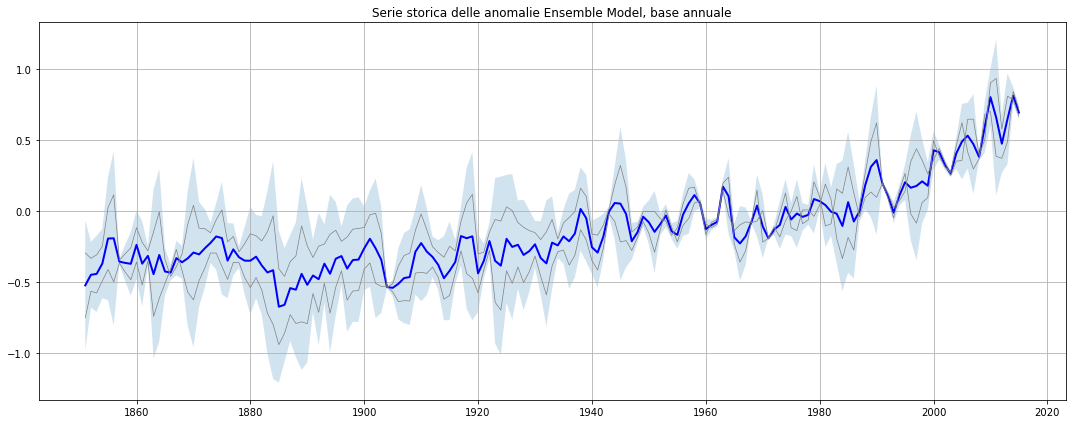

In [32]:
# Rappresentazione della media annuale ensemble (in blu), le singole medie annuali dei due modelli (in grigio) e la dispersione per la media ensemble

fig = plt.figure(figsize=(15,6))

plt.plot(pd.date_range('1850-01', '2015-01', freq='Y'),data_anom_yr.ens_mean[:],color='blue',linewidth=2) 
plt.title('Serie storica delle anomalie Ensemble Model, base annuale')
plt.fill_between(pd.date_range('1850-01', '2015-01', freq='Y'), data_anom_yr.ens_mean-2*data_anom_yr.ens_std, data_anom_yr.ens_mean+2*data_anom_yr.ens_std, alpha= 0.2)
plt.plot(pd.date_range('1850-01', '2015-01', freq='Y'),data_anom_yr.ts[:],color='gray',linewidth=0.7)
plt.plot(pd.date_range('1850-01', '2015-01', freq='Y'),data_anom_yr.ts2[:],color='gray',linewidth=0.7)
plt.grid()
fig.tight_layout()  
plt.show() 

## Confronto tra le osservazioni ed il modello ensemble

Esposti i modelli e calcolate le anomalie si procede con un paragone dei risultati ottenuti.  

Per prima cosa si calcola il bias del modello ensemble.  
Questo è ottenuto come differenza tra la temperatura media effettivamente registrata dalle stazioni di osservazione, pesata per tenere conto delle differenze nell'area delle celle, e la temperatura media stimata dal modello ensemble, anch'essa pesata nello stesso modo. Da questo confronto emerge come, per la maggior parte delle celle, la differenza sia molto bassa; la differenza media su tutta la mappa è di 1.36 gradi, con una deviazione standard di 4.05.
Una rappresentazione grafica del bias per ogni cella è fornita subito dopo il calcolo.

Infine si torna a considerare le anomalie.  
In particolare le due serie temporali ottenute precedentemente, una per il dataset delle osservazioni, una per il modello ensemble, sono confrontate sullo stesso grafico. Da questo paragone risulta che il modello ensemble segue abbastanza bene il trend delle osservazioni, anche se, spesso, i valori puntuali sono più spostati. La maggiore differenza si ha per i valori dal 1995 in poi, da quel momento, infatti, il modello ensemble sottostima costantemente le anomalie reali.  
Questo risultato è confermato anche dal test statistico svolto sul periodo 1985-2015; esso dimostra come, sebbene la differenza in media tra i due modelli non sia molto elevata, le due serie non possono ritenersi statisticamente uguali.

In [33]:
# Calcolo del Bias del modello ensemble nella media

mean_time = ens_geo.ens_mean_time
mean_time = mean_time.interp_like(stat_mean_time)

difference = mean_time - stat_mean_time

print(f'differenza media totale: {float(difference.mean())}, deviazione standard media totale: {float(difference.std())}')

differenza media totale: 1.3616280367918399, deviazione standard media totale: 4.050521194700237


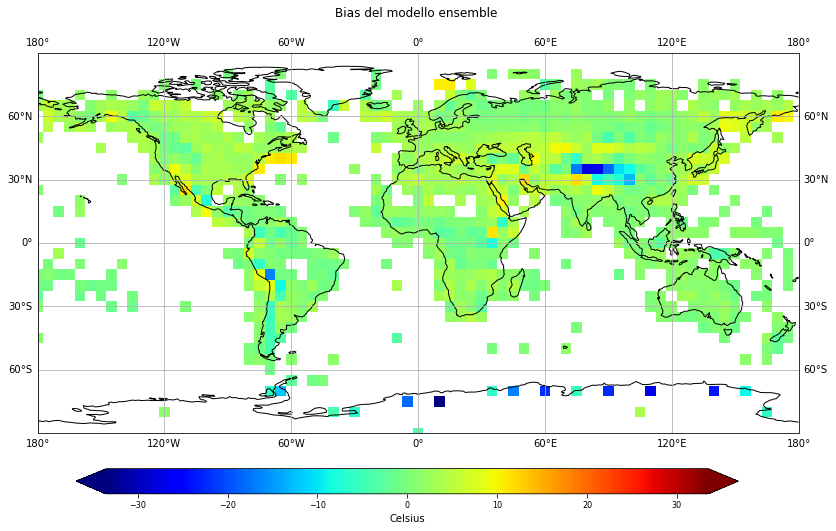

In [87]:
# Rappresentazione grafica del Bias del modello ensemble nella media

fig1 = plt.figure(figsize=(20,7))

ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.set_title(' '.join(['Bias del modello ensemble', '\n']))
ax1.set_global()
mm1 = ax1.pcolormesh(difference.lon, difference.lat, difference, \
                   transform=ccrs.PlateCarree(),cmap='jet', norm=norm, shading='auto' )  
ax1.coastlines()
ax1.gridlines(draw_labels=True)

# colorbar
cbar_ax = fig1.add_axes([0.275, 0.005, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig1.colorbar(mm1, cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.75)
cbar.set_label('Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

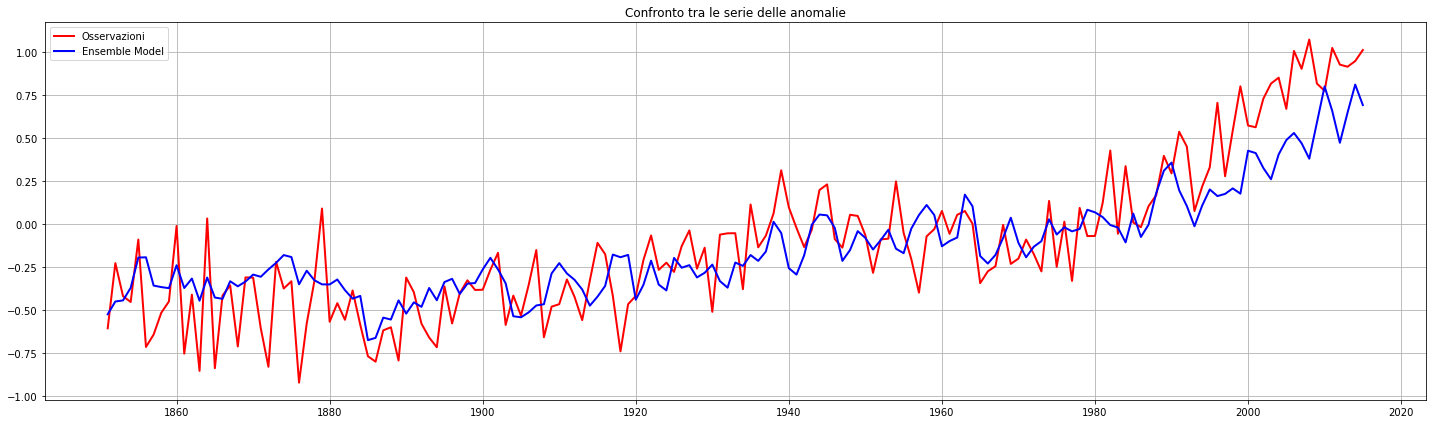

In [46]:
# Plot delle due curve delle anomalie

fig = plt.figure(figsize=(20,6))

plt.title('Confronto tra le serie delle anomalie')
plt.plot(pd.date_range('1850-01', '2015-01', freq='Y'), data_glob[:-7],color='red',linewidth=2, label = 'Osservazioni') 
plt.plot(pd.date_range('1850-01', '2015-01', freq='Y'),data_anom_yr.ens_mean[:],color='blue',linewidth=2, label = 'Ensemble Model')
plt.grid()
plt.legend()
fig.tight_layout()  
plt.show() 

In [36]:
# Statistica test sulle serie delle anomalie per il periodo 1985-2015

statistica_test = stats.ttest_ind(data_glob[-37:-7], data_anom_yr.ens_mean[-30:], equal_var = False) #1985-2015

print(f'Differenza tra le medie : {float((data_glob[-37:-7].mean())-(data_anom_yr.ens_mean[-30:].mean()))}')
print(f'{statistica_test}, la differenza è statisticamente significativa')  

Differenza tra le medie : 0.2674880340746504
Ttest_indResult(statistic=3.674830438541573, pvalue=0.0005531150583943269), la differenza è statisticamente significativa


## EOF

Come ultima analisi si propone una analisi mediante Empirical Orthogonal Function (EOF) per cercare dei pattern interessanti nelle anomalie.
Per questa analisi il modello utilizzato è quello ensemble, a livello geografico è considerata la porzione di mondo che copre la Cina e l'India e, come anomalie, sono isolate quelle che vanno dall'anno 1985 all'anno 2015, durante questo periodo temporale, infatti, entrambi i paesi sono andati incontro ad una importante rivoluzione industriale, con conseguente aumento delle emissioni. Lo scopo è quindi quello di verificare se vi siano dei pattern interessanti nelle anomalie.

Per prima cosa si propone un grafico della zona geografica di riferimento e della media delle anomalie per il periodo considerato.
Poi si procede a calcolare i pesi con cui correggere per la distorsione dell'area delle celle e a calcolare il numero ottimale di componenti principali da considerare nell'analisi. In particolare, dal grafico dei componenti si evince che solo le prime due componenti spiegano già più del 90% della varianza totale.
Infine si mostra il risultato dell'analisi EOF sulla zona di interesse e si commentano i risultati ottenuti.

In [40]:
# Ceazione dataset per l'analisi EOF

data_anom_mean_geo = data_anom_ens.to_array(dim='new').mean('new')
data_anom_std_geo = data_anom_ens.to_array(dim='new2').std('new2')

data_anom_ens['ens_mean_geo'] = data_anom_mean_geo
data_anom_ens['ens_std_geo'] = data_anom_std_geo

data_anom_ens

<xarray.Dataset>
Dimensions:       (lat: 143, lon: 144, time: 1980)
Coordinates:
  * lat           (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon           (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * time          (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12...
Data variables:
    ts            (time, lat, lon) float32 -0.03622 -0.03622 ... 5.243 5.243
    ts2           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ens_mean_geo  (time, lat, lon) float64 -0.03622 -0.03622 ... 5.243 5.243
    ens_std_geo   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

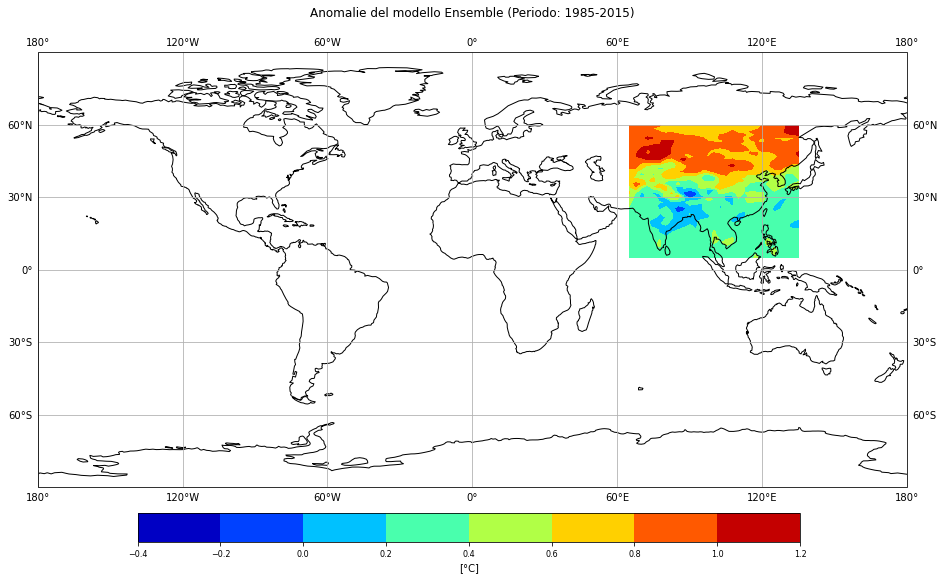

In [41]:
# Delimitazione dello spazio e del tempo al periodo e luogo di interesse

anom_sel = data_anom_ens.sel(lat=slice(5,60), lon=slice(65,135))
anom_sel_time = anom_sel.sel(time=slice("1985-01-16T12:00:00.000000000", "2015-12-16T12:00:00.000000000"))
ts_nat = anom_sel_time.ens_mean_geo.mean('time')

# Plot della media delle anomalie per il periodo 1985-2015 su Cina e India

fig = plt.figure(figsize=(20,8)) 

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(''.join(['Anomalie del modello Ensemble (Periodo: 1985-2015)','\n']))
ax.set_global()
mm = ax.contourf(ts_nat.lon, ts_nat.lat, ts_nat, \
                   transform=ccrs.PlateCarree(),cmap=mpl.cm.jet )   

ax.coastlines()
ax.gridlines(draw_labels=True)

# colorbar
cbar_ax = fig.add_axes([0.28, 0.03, 0.46, 0.05])
cbar = fig.colorbar(mm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('[°C]')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

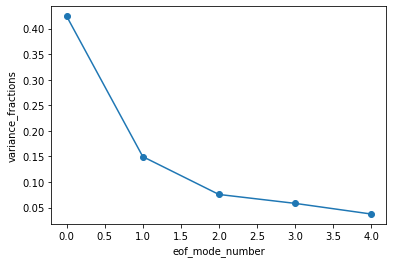

In [42]:
# Calcolo dei pesi con cui compensare la distorsione delle aree

ens_mean_geo_year = anom_sel_time.ens_mean_geo.resample(time="Y").mean()
wgts = np.cos(np.deg2rad(ens_mean_geo_year.lat.values))[..., np.newaxis]

# EOF sulle aree pesate 

neofs=5
solver = Eof(ens_mean_geo_year, weights=wgts)

eofs_w = solver.eofsAsCovariance(neofs=neofs)
pcs_w = solver.pcs(npcs=5, pcscaling=1)

# Calcolo della frazione di varianza spiegata per ogni componente principale e plot del grafico

variance_fractions_w = solver.varianceFraction(neigs=neofs)
variance_fractions_w.plot(marker='o')

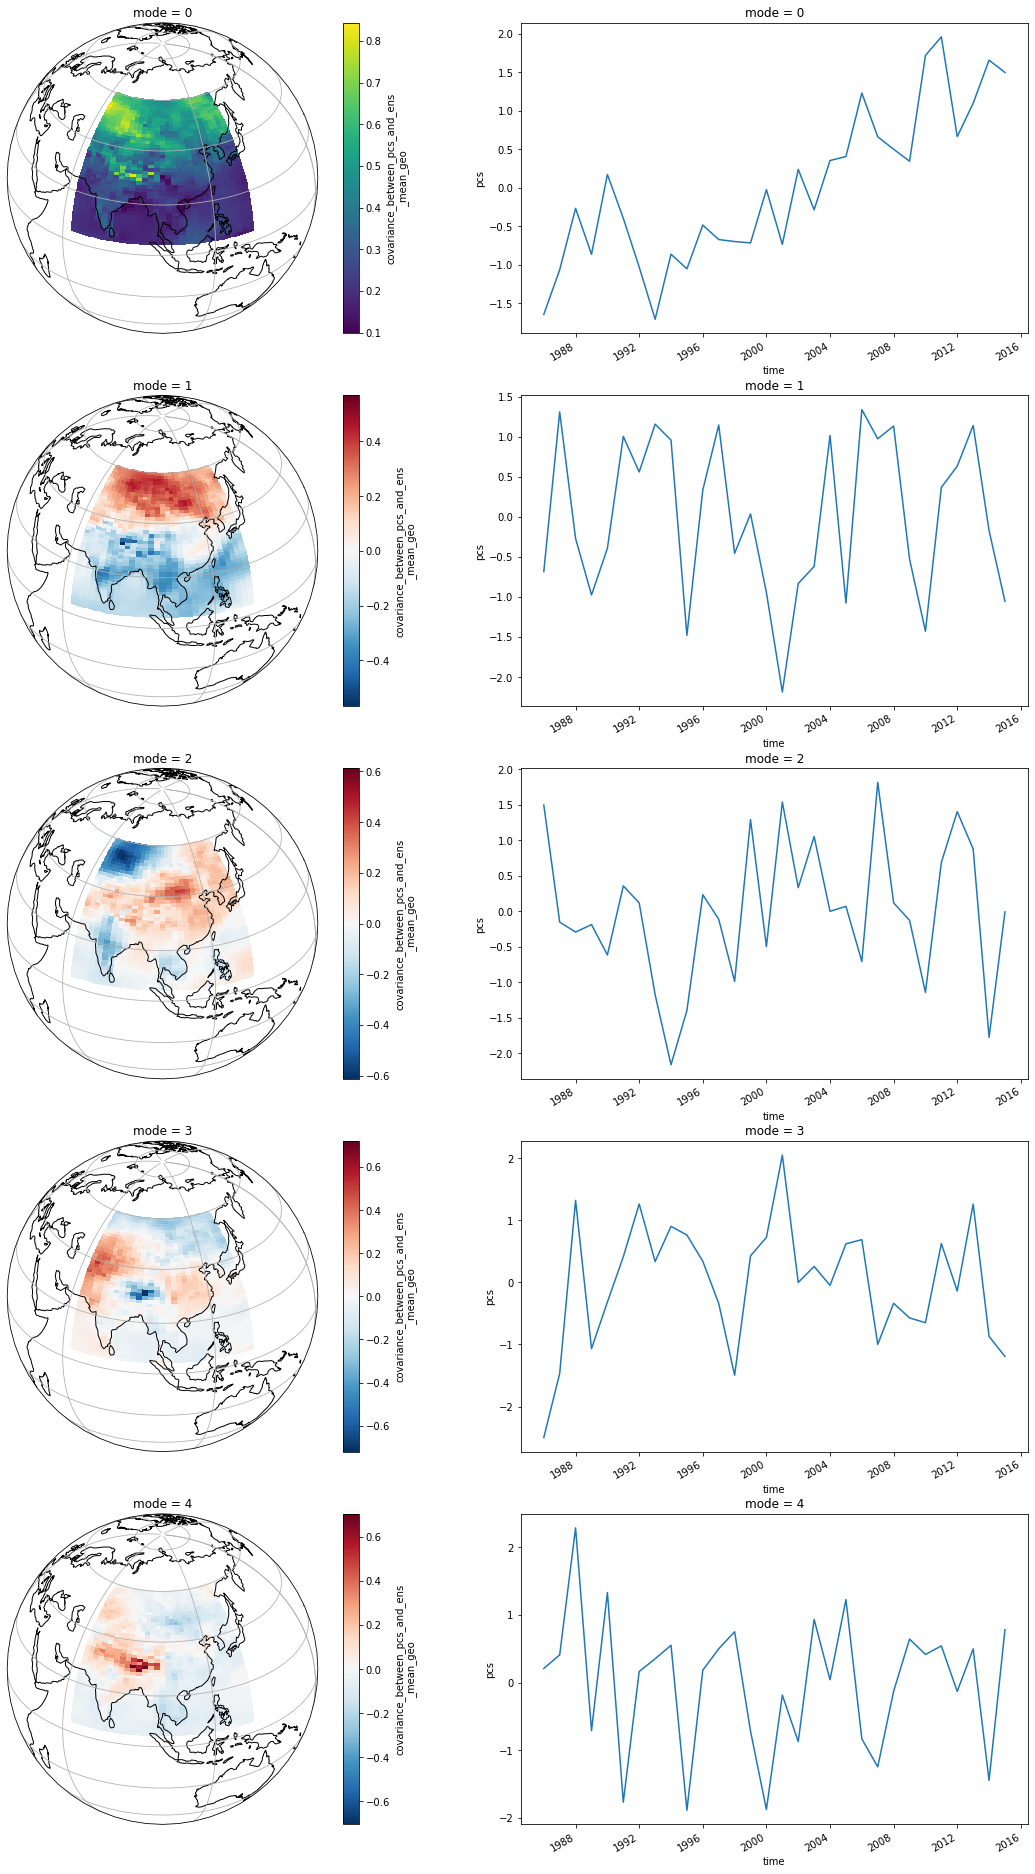

In [43]:
# Rappresentazione grafica degli EOF e dell'evoluzione nel tempo delle rispettive pcs

no=neofs

fig = plt.figure(figsize=(20,40))
subplots = (no+1,2)
n_vpanels = subplots[0] * subplots[1]

c=1

for i in range(0,no):
  ax = fig.add_subplot(subplots[0], subplots[1], c, 
                       projection=ccrs.Orthographic(central_longitude=100, central_latitude=30))
  ax.set_global()
  eofs_w[i,:,:].plot(transform=ccrs.PlateCarree())
  ax.gridlines()
  ax.coastlines() 
  c += 1
    
  ax = fig.add_subplot(subplots[0], subplots[1], c)
  pcs_w[:,i].plot()
  c += 1  


Come accennato le componenti pù significative sono le prime due.

Sotto un profilo temporale la prima evidenzia un pattern di salita nelle anomalie della temperatura lungo tutto il periodo considerato.

Da un punto di vista strettamente spaziale si trova come, per entrambe le prime due componenti, la zona più a nord del settore considerato abbia provocato i maggiori aumenti nelle anomalie. In particolare si registra un pattern di aumento delle anomalie per la zona a nord della Cina, mentre, le zone della Cina e dell'India stesse, registrano un aumento proporzionalmente molto più contenuto. 